In [4]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp 
import jax 
import equinox as eqx
import optax
import jax.tree_util as jtu
import random
from jaxtyping import Array, Float, Int, PyTree

In [5]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
BATCH_COUNT = 32
LATENT_DIMS = 64

Lets load some images.

In [19]:
def load_data(path : str, count : int):
    # load all images from this path
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images

def resize(images : list, size : int, batch_size : int, batch_count : int):
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    images = jnp.array(images)
    images = images / 255.0
    # clamp to [0, 1]
    images = jnp.clip(images, 0, 1)
    return images

images_raw = load_data("data", count=BATCH_SIZE * BATCH_COUNT)
random.shuffle(images_raw)
images_processed = resize(images_raw, size=IMAGE_SIZE, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT)

In [21]:
# write images to disk
for i, image in enumerate(images_processed):
    plt.imsave(f"data_processed/{i}.jpg", image)

In [22]:
def make_batches(images : jnp.ndarray, batch_size : int, batch_count : int, size : int):
    batches = images.reshape((batch_count, batch_size, size, size, 3))
    batches = jnp.transpose(batches, (0, 1, 4, 2, 3))
    return batches

batches = make_batches(images_processed, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT, size=IMAGE_SIZE)

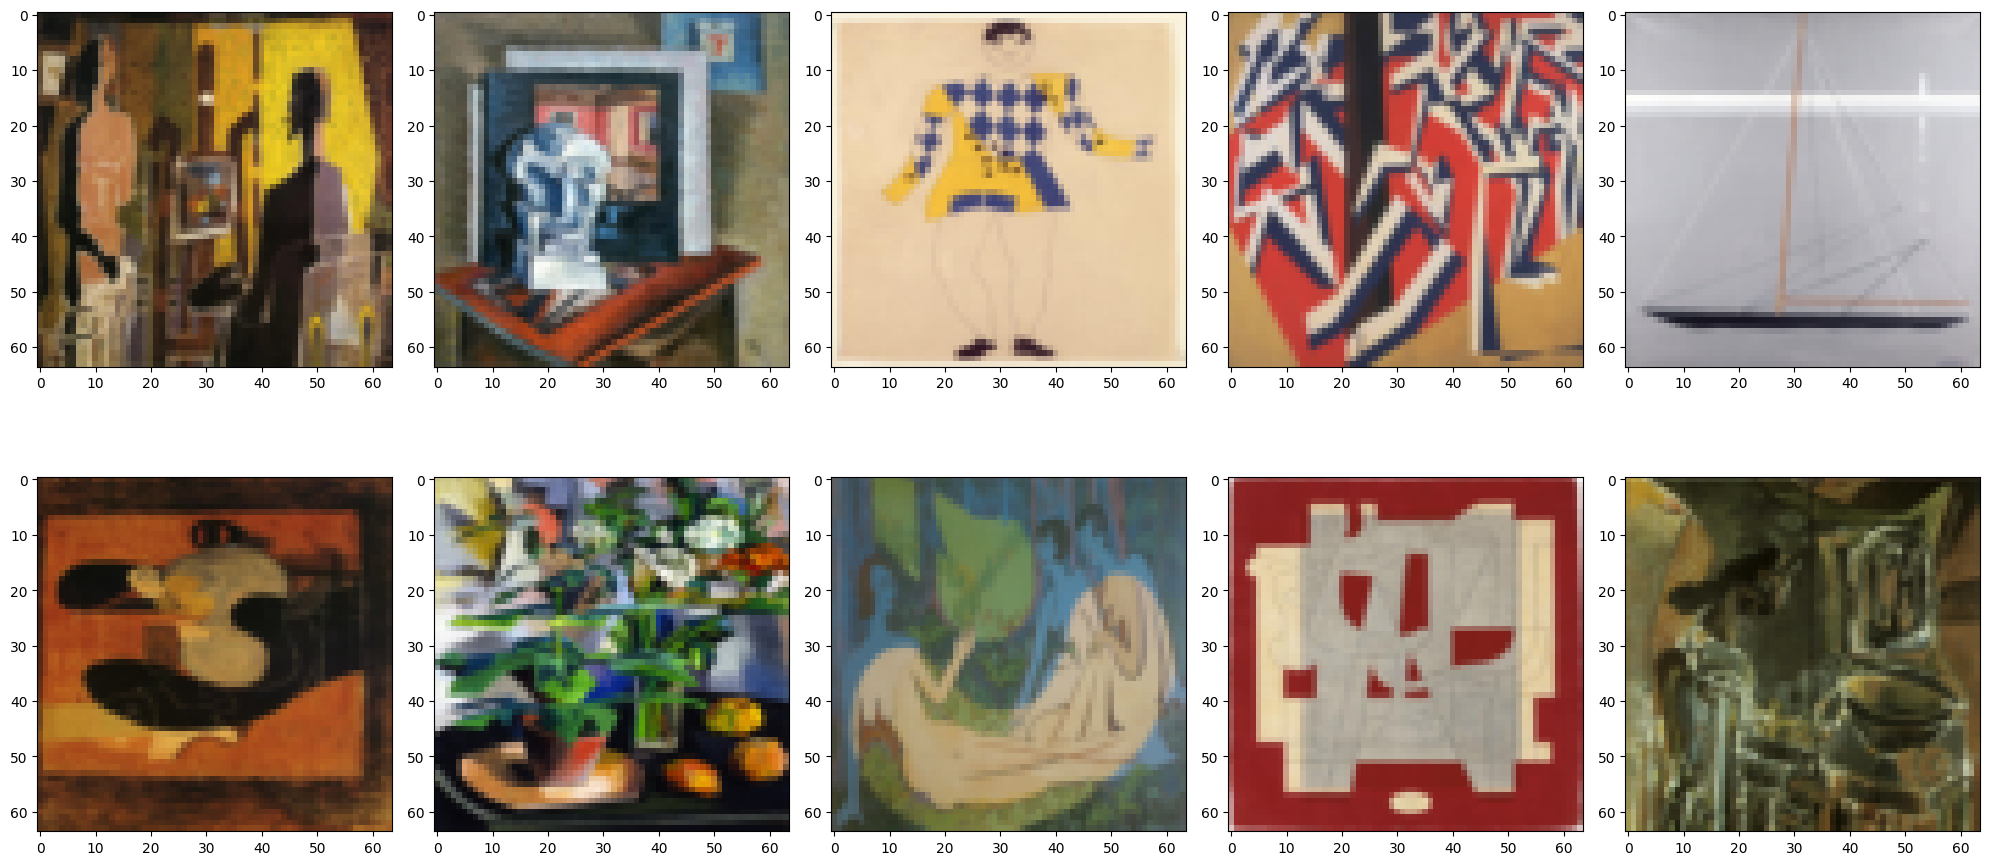

In [23]:
# generate 5 plots in a row
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0, i].imshow(jnp.transpose(batches[0, i], (1, 2, 0)))
    axs[1, i].imshow(jnp.transpose(batches[1, i], (1, 2, 0)))

# tight layout
plt.tight_layout()

In [151]:
class Generator(eqx.Module):
    layers : list
    
    def __init__(self, 
            key, 
            latent_dim : int, 
            output_dim : int, 
            hidden_dim : int,
            n_channels : int):
    

        if jnp.sqrt(latent_dim) % 1 != 0:
            raise ValueError("latent_dim must be a perfect square")
        
        latent_sqrt = jnp.sqrt(latent_dim).astype(jnp.int32)

        # evaluate number of upscaling layers we need to get to the output_dim
        dim = latent_sqrt
        upscaling_layers = 0
        while dim < output_dim:
            dim *= 2
            upscaling_layers += 1

        print(f"upscaling layers: {upscaling_layers}")
        print(f"hidden size: {hidden_dim}")

        keys = jax.random.split(key, upscaling_layers + 1)

        # first layer maps latent vector to a grid of size hidden_size x latent_sqrt x latent_sqrt
        self.layers = [
            eqx.nn.Linear(
                key=keys[0],
                in_features=latent_dim,
                out_features=latent_dim * hidden_dim),
            jax.nn.leaky_relu,
            lambda x: jnp.reshape(x, (hidden_dim, latent_sqrt, latent_sqrt))]

        for i in range(upscaling_layers):
            self.layers.append(
                eqx.nn.ConvTranspose(
                    key=keys[i + 1],
                    num_spatial_dims=2,
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=4,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)

        # we add another conv without stride to get to the desired output_dim
        self.layers.append(
            eqx.nn.ConvTranspose(
                key=keys[-1],
                num_spatial_dims=2,
                in_channels=hidden_dim,
                out_channels=n_channels,
                kernel_size=3,
                padding=1,
                stride=1))
        
        self.layers.append(jax.nn.tanh)

    def __call__(self, z : Float[Array, "LATENT_DIM"]):
        for layer in self.layers:
            z = layer(z)
        return z

In [152]:
class Critic(eqx.Module):
    layers : list

    def __init__(self, 
        key,
        input_dim : int, 
        hidden_dim : int,
        n_channels : int):

        dim = input_dim
        downscaling_layers = 0
        while dim > 1:
            dim = dim // 2
            downscaling_layers += 1

        print(f"downscaling layers: {downscaling_layers}")

        keys = jax.random.split(key, downscaling_layers * 2 + 2)

        self.layers = []

        self.layers.append(
            eqx.nn.Conv(
                key=keys[0],
                num_spatial_dims=2,
                in_channels=n_channels,
                out_channels=hidden_dim,
                kernel_size=3,
                padding=1,
                stride=1))
        self.layers.append(jax.nn.leaky_relu)

        for i in range(downscaling_layers):
            self.layers.append(
                eqx.nn.Conv(
                    key=keys[i*2+1],
                    num_spatial_dims=2,
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=3,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)
            self.layers.append(
                eqx.nn.Conv(
                    key=keys[i*2+2],
                    num_spatial_dims=2,
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=3,
                    padding=1,
                    stride=1))
            self.layers.append(jax.nn.leaky_relu)

        self.layers.append(
            eqx.nn.Conv(
                key=keys[-2],
                num_spatial_dims=2,
                in_channels=hidden_dim,
                out_channels=1,
                kernel_size=3,
                padding=1,
                stride=2))
        
        self.layers.append(lambda x: jnp.reshape(x, (1, )))

        
    def __call__(self, x : Float[Array, "3 IMAGE_SIZE IMAGE_SIZE"]):
        for layer in self.layers:
            x = layer(x)
        return x

In [153]:
def count_parameters(model: eqx.Module):
    return  sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [154]:
key = jax.random.PRNGKey(0)
key, gen_key, crit_key = jax.random.split(key, 3)

generator = Generator(
    key=gen_key,
    latent_dim=LATENT_DIMS,
    output_dim=IMAGE_SIZE,
    hidden_dim=32,
    n_channels=3)

print(f"Generator parameters: {count_parameters(generator)}")

critic = Critic(
    key=crit_key,
    input_dim=IMAGE_SIZE,
    hidden_dim=32,
    n_channels=3)

print(f"Critic parameters: {count_parameters(critic)}")


upscaling layers: 3
hidden size: 32
Generator parameters: 183235
downscaling layers: 6
Critic parameters: 112161


In [155]:
key, noise_key = jax.random.split(key, 2)
input_data = jax.random.normal(noise_key, (LATENT_DIMS, ))
output_data = generator(input_data)

critic_value = critic(output_data)

assert output_data.shape == (3, IMAGE_SIZE, IMAGE_SIZE)
assert critic_value.shape == (1,)


In [105]:
def generate_images(key, generator : Generator, count : int, latent_dims : int):
    z = jax.random.normal(key, (count, latent_dims))
    return jax.vmap(generator)(z)

def generator_loss_fn(
    generator : Generator, 
    key,
    critic : Critic):

    generated_images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)
    critic_vals = jax.vmap(critic)(generated_images)

    loss = -jnp.mean(jnp.log(jax.nn.sigmoid(critic_vals)))

    return loss

def critic_loss_fn(
    critic : Critic, 
    key,
    generator : Generator, 
    real_images : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    generated_images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)

    critic_vals_generated = jax.vmap(critic)(generated_images)
    critic_vals_real = jax.vmap(critic)(real_images)

    loss = -jnp.mean(jnp.log(jax.nn.sigmoid(critic_vals_real)) + jnp.log(jax.nn.sigmoid(1 - critic_vals_generated)))
    
    return loss

In [106]:
@eqx.filter_jit
def update_step(
    key,
    generator : Generator,
    critic : Critic,
    generator_optimizer : optax.GradientTransformation,
    critic_optimizer : optax.GradientTransformation,    
    generator_optimizer_state : optax.OptState,
    critic_optimizer_state : optax.OptState,
    batch : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    critic_key, generator_key = jax.random.split(key, 2)

    critic_loss, critic_grads = eqx.filter_value_and_grad(critic_loss_fn)( 
        critic, 
        critic_key,
        generator, 
        batch)
    
    # print(f"critic grad: {critic_grads}")
    
    critic_update, new_critic_optimizer_state =\
        critic_optimizer.update(critic_grads, critic_optimizer_state)
    new_critic = eqx.apply_updates(critic, critic_update)

    generator_loss, generator_grads = eqx.filter_value_and_grad(generator_loss_fn)(        
        generator,
        generator_key,
        critic)
    
    generator_update, new_generator_optimizer_state =\
        generator_optimizer.update(generator_grads, generator_optimizer_state)
    
    new_generator = eqx.apply_updates(generator, generator_update)

    return new_generator, new_critic, new_generator_optimizer_state, new_critic_optimizer_state, generator_loss, critic_loss
    

In [156]:
optimizer_critic = optax.adam(1e-5)
optimizer_generator = optax.adam(1e-5)

optimizer_critic_state = optimizer_critic.init(eqx.filter(critic, eqx.is_array))
optimizer_generator_state = optimizer_generator.init(eqx.filter(generator, eqx.is_array))

num_epochs = 100

critic_losses = []
generator_losses = []
for epoch in range(num_epochs):

  epoch_loss_critic = 0.0
  epoch_loss_generator = 0.0

  for i in range(len(batches)):
    generator, critic, optimizer_generator_state, optimizer_critic_state, generator_loss, critic_loss = update_step(
      key, 
      generator, 
      critic,
      optimizer_generator,
      optimizer_critic,
      optimizer_generator_state,
      optimizer_critic_state,
      batches[i])

    epoch_loss_critic += critic_loss
    epoch_loss_generator += generator_loss

  epoch_loss_critic /= len(batches)
  epoch_loss_generator /= len(batches)
  critic_losses.append(critic_loss)
  generator_losses.append(generator_loss)

  print(f"Epoch {epoch} - Critic loss: {epoch_loss_critic} - Generator loss: {epoch_loss_generator }")
  

Epoch 0 - Critic loss: 0.9943963885307312 - Generator loss: 0.6660670638084412
Epoch 1 - Critic loss: 0.9942578673362732 - Generator loss: 0.6657406091690063
Epoch 2 - Critic loss: 0.9941173195838928 - Generator loss: 0.6654090285301208
Epoch 3 - Critic loss: 0.993975818157196 - Generator loss: 0.6650746464729309
Epoch 4 - Critic loss: 0.9938324689865112 - Generator loss: 0.6647360324859619
Epoch 5 - Critic loss: 0.9936861991882324 - Generator loss: 0.6643901467323303
Epoch 6 - Critic loss: 0.9935356974601746 - Generator loss: 0.6640353798866272
Epoch 7 - Critic loss: 0.9933764338493347 - Generator loss: 0.6636641025543213
Epoch 8 - Critic loss: 0.9932040572166443 - Generator loss: 0.6632800102233887
Epoch 9 - Critic loss: 0.9929919242858887 - Generator loss: 0.6628708839416504
Epoch 10 - Critic loss: 0.992641270160675 - Generator loss: 0.6623997688293457
Epoch 11 - Critic loss: 0.9916660785675049 - Generator loss: 0.6617704033851624
Epoch 12 - Critic loss: 0.9869524836540222 - Generat

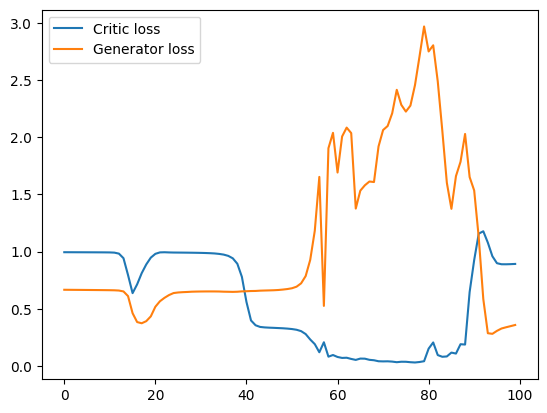

In [157]:
# plot the losses
plt.plot(critic_losses)
plt.plot(generator_losses)
plt.legend(["Critic loss", "Generator loss"])
plt.show()

(5, 3, 64, 64)


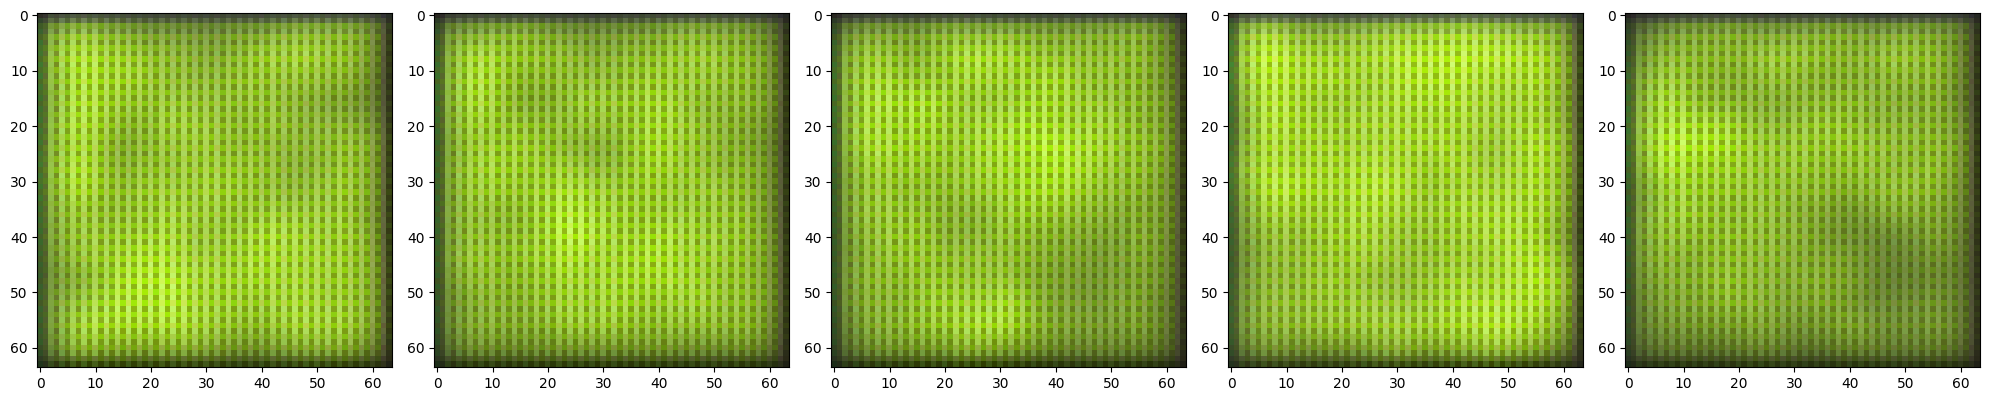

In [158]:
# generate some images
images = generate_images(key, generator, 5, LATENT_DIMS)
print(images.shape)
# normalize images

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    img = jnp.transpose(images[i], (1, 2, 0))
    # normalize image
    img = (img - jnp.min(img)) / (jnp.max(img) - jnp.min(img))
    axs[i].imshow(img)
plt.tight_layout()
